<img
    style="border-radius: 0.5em;"
    src="https://ucfai.org/groups/projects/fa19/nfl-intro/banner.png">

<div class="col-12">
    <h1> Introducing the NFL Big Data Bowl </h1>
    <hr>
</div>

<div style="line-height: 2em;">
    <p>by: 
        <a href="https://ucfai.org/authors/ahkerrigan">@ahkerrigan</a> on Oct 17, 2019</p>
</div>

In [ ]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input")
if (DATA_DIR / "ucfai-projects-fa19-nfl-intro").exists():
    DATA_DIR /= "ucfai-projects-fa19-nfl-intro"
elif DATA_DIR.exists():
    # no-op to keep the proper data path for Kaggle
    pass
else:
    # You'll need to download the data from Kaggle and place it in the `data/`
    #   directory beside this notebook.
    # The data should be here: https://kaggle.com/c/ucfai-projects-fa19-nfl-intro/data
    DATA_DIR = Path("data")

**Importing Required Libraries**

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from kaggle.competitions import nflrush

from keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tqdm

Using TensorFlow backend.


## Getting a basic Idea
- Each row of the train dataframe contains the attributes of a single player in the match with the target value.
- There are 22 players in a single game.
- Each of this 22 player participating in game has a row.
- This mean that we have 509762 / 22 = 23171 samples effectively.
- There are many missing values in different columns,WindSpeed, WindDirection, Temperature, GameWeather, Humidity, StadiumType, and FieldPosition.
- We will preprocess the data and make it in a trainable form.



## Setting up the environment

**It's important to note that this competition has its own API.**

This time around, we aren't going to concatonate train and test, because the way data is handled
here is a little wonky. This means after we feature engineer and clean the train, we, yes, have
to do it all over again to the test.

In [2]:
# First, let's build the enviroment from the API
env=nflrush.make_env()
df_train=pd.read_csv(DATA_DIR / 'nfl-big-data-bowl-2020/train.csv',low_memory=False)

In [3]:
df_train

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509760,2018123015,20181230154157,home,84.57,24.37,4.36,1.79,0.47,148.08,183.34,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE


In [4]:
print('The train dataframe contrains {} rows and {} columns'.format(df_train.shape[0],df_train.shape[1]))

The train dataframe contrains 509762 rows and 49 columns


##  handling missing values...



In [5]:
df_train.isna().sum().sort_values(ascending=False)

WindDirection             80234
WindSpeed                 67430
Temperature               48532
GameWeather               43648
StadiumType               32934
FieldPosition              6424
Humidity                   6160
OffenseFormation            110
DefendersInTheBox            66
Orientation                  18
Dir                          14
NflId                         0
PossessionTeam                0
GameClock                     0
Quarter                       0
YardLine                      0
Season                        0
JerseyNumber                  0
DisplayName                   0
Stadium                       0
Distance                      0
Dis                           0
A                             0
S                             0
Y                             0
X                             0
Team                          0
PlayId                        0
Down                          0
Turf                          0
Week                          0
Yards   

### Let's start by trying to fix windspeed

In [6]:
df_train['WindSpeed'].value_counts()

5                    53284
6                    41580
7                    39578
4                    34584
9                    31328
10                   29788
8                    29370
3                    26862
2                    24112
12                   23584
11                   17116
15                   13926
0                    13772
1                    12078
16                    9878
13                    8404
14                    6094
17                    3872
18                    1980
13 MPH                1804
23                    1166
E                     1144
SE                    1122
7 MPH                 1100
Calm                  1100
10-20                 1100
12-22                 1056
6 mph                 1034
20                    1012
12mph                  968
24                     968
14-23                  968
4 MPh                  902
10mph                  902
10MPH                  902
SSW                    836
15 gusts up to 25      836
2

### Alright so this data is not very consistent with how wind speed is labeled, so lets fix that

- There are many different type of values in Windspeed,we will clean them.
- We will remove mph/MPH if its present
- we will return average value if there is a range of values eg(11 - 15).


In [7]:
def windspeed(x):
    x=str(x)
    if x.isdigit():
        return int(x)
    elif (x.isalpha()):
        return 0
    elif (x.isalnum()):
        return int(x.upper().split('M')[0])                             #return 12 incase of 12mp or 12 MPH
    elif '-' in x:
        return int((int(x.split('-')[0])+int(x.split('-')[1]))/2)   # return average windspeed incase of 11 - 20 etc..
    else:
        return 0

### We are going to use a very nice pandas feature that YOU ALL should know
By using .apply(function) to some column in a dataframe, you can apply that function individually to all items 

In [8]:
# Let's just apply our fix to the messed up values 
df_train['WindSpeed']=df_train['WindSpeed'].apply(windspeed)
# Then, lets just fill the missing values with the average, as we have been doing 
df_train['WindSpeed'].fillna(df_train['WindSpeed'].mean(),inplace=True)

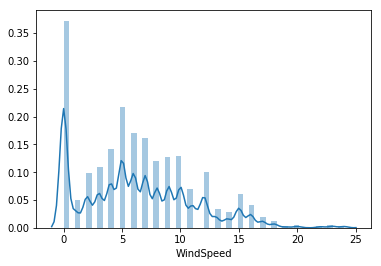

In [9]:
sns.distplot(df_train['WindSpeed'])

Yeh,We have cleaned all the windspeed values.

### WindDirection values

Wind direction was much worse, so let's take a look at that

In [10]:
df_train['WindDirection'].value_counts()

NE                 30250
NW                 27236
SW                 25828
SE                 25784
WSW                24222
N                  23188
W                  22198
S                  21384
NNE                20394
South              20328
SSW                19910
WNW                19118
North              17182
NNW                14036
West               13618
SSE                13376
E                  12826
ENE                10802
ESE                 9878
East                7348
Northwest           4070
From SW             3872
Northeast           3652
NorthEast           3212
From S              3146
s                   2728
SouthWest           2134
Southeast           1936
W-NW                1804
Southwest           1804
West-Southwest      1386
8                   1144
1                   1122
North East          1100
East Southeast      1078
Calm                1056
West Northwest      1056
N-NE                1012
From W               990
North/Northwest      968


In [11]:
# So wind direction is a bit confusing in that it is all base on WHERE it comes from
# We can see that it has the same problem as wind speed: multiple wants for saying the same thing.
# So we need to handle these cases indv
# We are going to reduce the number of options a bit 

def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM N' in wd:
        return 'north'
    if wd == 'S' or 'FROM S' in wd:
        return 'south'
    if wd == 'W' or 'FROM W' in wd:
        return 'west'
    if wd == 'E' or 'FROM E' in wd:
        return 'east'
    
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'south west'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'south east'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'north west'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'north east'
    
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'none'

df_train['WindDirection'] = df_train['WindDirection'].apply(clean_wind_direction)

**Unhide above cell**

### Handling humidity and Temperature
Since we are working with a time series, we have a nice benifit that there is a trick to filling empty vales
You can just use something called "forward filling", which just fills all empty values with the last known value
Say at 3:00pm I know that the temp was 80 degrees, and then didn't record for 10 hours
Forward will will just fill everything for the next 10 hours with 80 degrees

In [12]:
df_train['Humidity'].fillna(method='ffill', inplace=True)
df_train['Temperature'].fillna(method='ffill', inplace=True)


### Handling Game wheather and Stadium types
For some other values, we are going to build what is called a na map
Its just a python dictionary that maps columns to the rule for filling t hem

In [13]:
na_map = {
    # What is the average orientation of the playrees
    'Orientation': df_train['Orientation'].mean(),
    # Average direction 
    'Dir': df_train['Dir'].mean(),
    # Average # of defenders in the box (# of defenders directly opposing person with the ball)
    'DefendersInTheBox': np.math.ceil(df_train['DefendersInTheBox'].mean()),
    # What formation the team is using is really important, but often some teams use custom formations
    # In the case we will just say that we don't know
    'OffenseFormation': 'UNKNOWN'
}

df_train.fillna(na_map, inplace=True)


In [14]:
df_train['GameWeather'].value_counts()

Cloudy             114466
Sunny              105028
Partly Cloudy       46068
Clear               44264
Rain                18898
                    ...  
Rain Chance 40%       836
Party Cloudy          814
Sunny, Windy          792
Partly clear          770
Rainy                 704
Name: GameWeather, Length: 61, dtype: int64

Yeah this is insane, there are only 4 weather types that really matter
rain, overcast, clear, snow, and if players are climate controlled (indoors etc)
Here, we will make a function that first creates a list of all the different types we have 
(Unfortunately if you're doing this on your own you'll need to find each of these yourself)
Then, just determine which box the weather belongs to and change it to that

In [15]:
def group_game_weather(weather):
    rain = [
        'Rainy', 'Rain Chance 40%', 'Showers',
        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain'
    ]
    overcast = [
        'Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
        'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
        'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
        'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
        'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
        'Partly Cloudy', 'Cloudy'
    ]
    clear = [
        'Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
        'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
        'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
        'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
        'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
        'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny'
    ]
    snow  = ['Heavy lake effect snow', 'Snow']
    none  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 'rain'
    elif weather in overcast:
        return 'overcast'
    elif weather in clear:
        return 'clear'
    elif weather in snow:
        return 'snow'
    elif weather in none:
        return 'none'
    
    return 'none'

df_train['GameWeather'] = df_train['GameWeather'].apply(group_game_weather)

df_train['FieldPosition'] = np.where(df_train['YardLine'] == 50, df_train['PossessionTeam'], df_train['FieldPosition'])

## Stadium types
Again, let's reduce the number of stadiums types the same way we did with weather.
There is no difference between "Indoors" and "Indoor" obviously

In [16]:
df_train

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,clear,63.0,77.0,8,south west
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,clear,63.0,77.0,8,south west
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,clear,63.0,77.0,8,south west
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,clear,63.0,77.0,8,south west
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,clear,63.0,77.0,8,south west
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,overcast,45.0,76.0,5,south east
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,overcast,45.0,76.0,5,south east
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,overcast,45.0,76.0,5,south east
509760,2018123015,20181230154157,home,84.57,24.37,4.36,1.79,0.47,148.08,183.34,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,overcast,45.0,76.0,5,south east


In [17]:
def group_stadium_types(stadium):
    outdoor       = [
        'Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
        'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
        'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl'
    ]
    indoor_closed = [
        'Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
        'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',
    ]
    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 'outdoor'
    elif stadium in indoor_closed:
        return 'indoor closed'
    elif stadium in indoor_open:
        return 'indoor open'
    elif stadium in dome_closed:
        return 'dome closed'
    elif stadium in dome_open:
        return 'dome open'
    else:
        return 'unknown'
    
df_train['StadiumType'] = df_train['StadiumType'].apply(group_stadium_types)

**Unhide above cell**
- The stadium types and weather is cleaned.

### BirthDate, GameHour and Time
- we will extract and consider Birth year of each player
- We will extract and consider Hour from GameClock
- We will calucate TimeDelta by subtracting TimeSnap from TimeHandoff .


In [18]:
df_train['TimeHandoff'] = df_train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
df_train['TimeSnap'] = df_train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
df_train['TimeDelta'] = df_train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
df_train.drop(['TimeSnap','TimeHandoff'],axis=1,inplace=True)

In [19]:
df_train['BirthYear']=df_train['PlayerBirthDate'].apply(lambda x : int(x.split('/')[2]))
df_train['GameHour']=df_train['GameClock'].apply(lambda x : int(x.split(':')[0]))

df_train.drop(['PlayerBirthDate',"GameClock"],axis=1,inplace=True)

In [20]:
df_train['PlayerHeight']=df_train['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))
#df_train.drop('PlayerHeight',axis=1,inplace=True)                                                       

### DefensePersonnel


 - We will split the DefensePersonnel variable into **DL , LB ,  BL , OL**
 - We will filter them and store them as int variables.

In [21]:
def process_defense(x):
    num=[]
    num=x.split(',')
    dl=int(num[0].split(' ')[0])
    lb=int(num[1].split(' ')[1])
    db=int(num[2].split(' ')[1])
    if(len(num)>3):
         ol=int(num[3].split(' ')[1])
    else:
         ol=0
    return [dl,lb,db,ol]

values=df_train['DefensePersonnel'].apply(process_defense)


In [22]:
u,v,x,y=list(map(list,zip(*values)))

In [23]:
df_train['DL']=u
df_train['LB']=v
df_train['BL']=x
df_train['OL']=y
df_train.drop(['DefensePersonnel'],axis=1,inplace=True)

In [24]:
df_train.shape

(509762, 51)

## Encoding values..
- In this step we will encode all categorical variables.
- we will use Label Encoding for this.
- we will store each of instances in a dictionary for later use during test set preparation.

In [25]:
new_obj=[]
for c in df_train.columns:
    if(df_train[c].dtype != int):
            try:
                df_train[c]=df_train[c].astype('float16')
            except:
                new_obj.append(c)

In [26]:
lbdic={}
for c in new_obj:
    lb=LabelEncoder()
    lb=lb.fit(df_train[c].values)
    lbdic[c]=lb
    df_train[c]=lb.transform(df_train[c].values)

## Data preparation

In the below session we will process and prepare data inorder to feed it to our model.
- First,we will drop some columns which are not relevant.
- we will classify our varibles into three lists ,is one,two and more.
- one contains variable having unique values.
- more contains variables having more than 2 different values.

In [27]:
columns_drop=['GameId','PlayId','NflId','NflIdRusher']
one=[]
two=[]
more=[]
for col in df_train.drop(columns_drop,axis=1).columns:
    if df_train[col][:22].nunique() <2:
        one.append(col)
    elif df_train[col][:22].nunique() <=2:
        two.append(col)
    else:
        more.append(col)
        

In [28]:
print('The number of attributes for preprocessing =',len(one)+len(two)+len(more))

The number of attributes for preprocessing = 47


During the next steps we will actually convert the data to our required form.Each row in the output dataframe will represent a game.Our target variable is Yards,which is the the yardage gained on the play.

In [29]:
# We're going to start by appending the variables that have more than two unique values
# Remember, every "example" is actually one of 11 timesteps from two seperate games, 
# For a total of 22 datapoints per player
new_cols=[]
for col in more:
    for i in range(0,11):
        new_cols.append(str(col)+'A'+str(i))
    for i in range(0,11):
         new_cols.append(str(col)+'B'+str(i))
        
        

In [30]:
train=pd.DataFrame()
x=np.tile(np.arange(0,22),14)

In [31]:
# Now we build the targets
out=[]
for c in more:
    for  i in range(0,22):
         out.append(df_train[i:len(df_train):22][c].values)
               
for col in zip(new_cols,np.arange(len(out))):
    train[col]=out[i]
out=np.array(out).transpose()

In [32]:
train=pd.DataFrame(data=out,columns=new_cols)
    

In [33]:
train.head()

,XA0,XA1,XA2,XA3,XA4,XA5,XA6,XA7,XA8,XA9,...,BirthYearB1,BirthYearB2,BirthYearB3,BirthYearB4,BirthYearB5,BirthYearB6,BirthYearB7,BirthYearB8,BirthYearB9,BirthYearB10
0,73.937500,74.687500,74.00000,71.437500,69.312500,75.062500,74.125000,73.375000,56.625000,73.375000,...,1989.0,1988.0,1988.0,1977.0,1987.0,1993.0,1992.0,1993.0,1992.0,1992.0
1,65.750000,66.062500,66.00000,63.312500,60.500000,66.625000,65.125000,65.187500,48.062500,64.437500,...,1989.0,1988.0,1988.0,1977.0,1987.0,1993.0,1992.0,1993.0,1992.0,1992.0
2,44.750000,44.375000,43.37500,41.968750,40.937500,44.625000,42.625000,39.875000,28.234375,42.281250,...,1989.0,1988.0,1988.0,1977.0,1987.0,1993.0,1992.0,1993.0,1992.0,1992.0
3,11.906250,9.671875,11.28125,11.171875,9.757812,10.867188,10.320312,11.132812,10.062500,9.203125,...,1988.0,1988.0,1977.0,1988.0,1990.0,1991.0,1990.0,1993.0,1992.0,1992.0
4,29.515625,33.187500,33.34375,31.359375,34.250000,33.625000,35.062500,36.187500,34.187500,33.812500,...,1987.0,1984.0,1990.0,1990.0,1991.0,1991.0,1990.0,1993.0,1993.0,1994.0


### In the next step we will group our dataframe using PlayId and select values from columns which are labelled as **one**.

In [34]:
df_one=df_train.groupby(['PlayId'])[one].first()
for col in df_one.columns:
    train[col]=df_one[col].values

Lets check our target variable distribution..

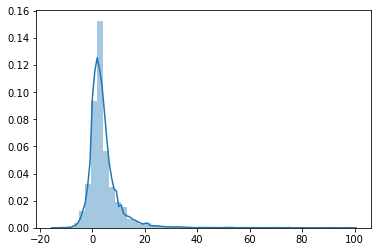

In [35]:
sns.distplot(train['Yards'].values)

In [36]:
not_object=[]
obj=[]
for col in more+one:
    if df_train[col].dtype != 'object':
        not_object.append(col)
    else:
        obj.append(col)

- We will split our train and taget variables.

In [37]:
# Split the features and target variables
X=train.drop('Yards',axis=1)
y=train['Yards']


## Keras model
- In this section we will use keras Sequencial models to build our model.
- We will use Dropout and BatchNormalization.


In [38]:
def create_model():
    model=Sequential()
    model.add(Dense(356,input_shape=[X.shape[1]],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.4))
    model.add(Dense(200,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.4))
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Dense(212,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Dense(199,activation='sigmoid'))

    optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(optimizer=optimizer,loss=['mse'],metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
    return model
model = create_model()

- We will also convert our Target variable to appropriate form.Ie 199 x 1 array.

In [39]:
def transform_y(X_train,y_train):
    Y_train=np.zeros((X_train.shape[0],199))
    for i,yard in enumerate(y_train):
        Y_train[i, yard+99:] = np.ones(shape=(1, 100-yard))
    
    return Y_train



## KFold cross validation..
Everyone remember how this works?

In [41]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=3,shuffle=True)

for train_ind,val in kfold.split(X,y):
    
    x_train,xval = X.iloc[train_ind],X.iloc[val]
    y_train,yval= y.iloc[train_ind],y.iloc[val]
    
    y_train=transform_y(x_train,y_train)
    y_val=transform_y(xval,yval)
    
    model=None
    model=create_model()
    
    history=model.fit(x_train,y_train,epochs=20,validation_data=[xval,y_val],verbose=1)
    print('validation accuracy : {}'.format(np.mean(history.history['val_accuracy'])))

Train on 15447 samples, validate on 7724 samples
Epoch 1/20
15447/15447 [==============================] - 7s 445us/step - loss: 0.0742 - accuracy: 0.0015 - val_loss: 0.0145 - val_accuracy: 2.5893e-04
Epoch 2/20
15447/15447 [==============================] - 5s 340us/step - loss: 0.0149 - accuracy: 1.2947e-04 - val_loss: 0.0142 - val_accuracy: 1.2947e-04
Epoch 3/20
15447/15447 [==============================] - 6s 367us/step - loss: 0.0145 - accuracy: 6.4737e-05 - val_loss: 0.0142 - val_accuracy: 2.5893e-04
Epoch 4/20
15447/15447 [==============================] - 6s 367us/step - loss: 0.0144 - accuracy: 6.4737e-05 - val_loss: 0.0141 - val_accuracy: 1.2947e-04
Epoch 5/20
15447/15447 [==============================] - 6s 364us/step - loss: 0.0143 - accuracy: 6.4737e-05 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 6/20
15447/15447 [==============================] - 5s 350us/step - loss: 0.0143 - accuracy: 6.4737e-05 - val_loss: 0.0141 - val_accuracy: 1.2947e-04
Epoch 7/20
15447/15

- We will also use learning rate reducer to reduce learning rate and help it converge easily to minima point.

## Model Evaluation

Text(0, 0.5, 'accuracy')

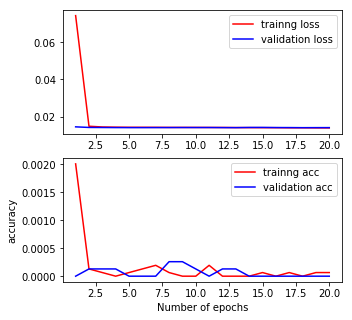

In [42]:
fig,ax=plt.subplots(2,1)
fig.set_size_inches((5,5))
epochs=20
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')
ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')

We have lot to improve !

## Making Prediction..

- This function is to prepare and predict on test data.
- We will have to replicate all the data processing steps that we have done above in this function.
- This ensures that our data is made fit for prediction.
- In this competition we will have to use **env.iter_test()** and **env.predict()**.


In [43]:
def make_prediction(test,sample,env,model,df_train):
    
    na_map = {
    'Orientation': df_train['Orientation'].mean(),
    'Dir': df_train['Dir'].mean(),
    'DefendersInTheBox': 7.0,
    'OffenseFormation': 'UNKNOWN','WindSpeed':df_train['WindSpeed'].mean()
    }

    test.fillna(na_map, inplace=True)
    test['Temperature'].fillna(61.0,inplace=True)
    test['WindSpeed']=test['WindSpeed'].apply(windspeed)
    #test['WindSpeed'].fillna(df_train['WindSpeed'].mean(),inplace=True)

    test['GameWeather'] = test['GameWeather'].apply(group_game_weather)
    test['FieldPosition'] = np.where(test['YardLine'] == 50, test['PossessionTeam'], test['FieldPosition'])
    test['StadiumType'] = test['StadiumType'].apply(group_stadium_types)
    test['WindDirection'] = test['WindDirection'].apply(clean_wind_direction)
    
    test['TimeHandoff'] = test['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    test['TimeSnap'] = test['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    test['TimeDelta'] = test.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    test.drop(['TimeSnap','TimeHandoff'],axis=1,inplace=True)
   
    test['PlayerHeight']=test['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))




    test['BirthYear']=test['PlayerBirthDate'].apply(lambda x : int(x.split('/')[2]))
    test['GameHour']=test['GameClock'].apply(lambda x : int(x.split(':')[0]))
    test.drop(['PlayerBirthDate',"GameClock"],axis=1,inplace=True)

    values=test['DefensePersonnel'].apply(process_defense)
    u,v,x,y=list(map(list,zip(*values)))
    test['DL']=u
    test['LB']=v
    test['BL']=x
    test['OL']=y
    test.drop(['DefensePersonnel'],axis=1,inplace=True)
    
    new_obj=[]
    for c in test.columns:
        if(test[c].dtype != int):
                try:
                    test[c]=test[c].astype('float16')
                except:
                    new_obj.append(c)

    for c in new_obj:
        try:
            test[c]=lbdic[c].transform(test[c].values)
        except:
            l=LabelEncoder()
            test[c]=l.fit_transform(test[c].values)
            
    
    columns_drop=['GameId','PlayId','NflId','NflIdRusher']
    one=[]
    two=[]
    more=[]
    for col in test.drop(columns_drop,axis=1).columns:
        if test[col][:22].nunique() <2:
            one.append(col)
        elif test[col][:22].nunique() <=2:
            two.append(col)
        else:
            more.append(col)
        

    new_cols=[]
    for col in more:
        for i in range(0,11):
            new_cols.append(str(col)+'A'+str(i))
        for i in range(0,11):
             new_cols.append(str(col)+'B'+str(i))

    

    out=[]
    for c in more:
        out.append(test[c].values)
    
   
    new_out=[]
    for i in out:
        for j in i:
            new_out.append(j)

    new_test=pd.DataFrame(data=[new_out],columns=new_cols)

    df_one=test.groupby(['PlayId'])[one].first()
    for col in df_one.columns:
        new_test[col]=df_one[col].values

    
    new_test.fillna(na_map,inplace=True)
    new_test['Temperature'].fillna(61.0,inplace=True)
        
    y_pred=np.zeros((1,199))
    
    y_pred = model.predict(new_test)
    
        
    for pred in y_pred:
        prev = 0
        for i in range(len(pred)):
            if pred[i]<prev:
                pred[i]=prev
            prev=pred[i]
    
    y_pred[:, -1] = np.ones(shape=(y_pred.shape[0], 1))
    y_pred[:, 0] = np.zeros(shape=(y_pred.shape[0], 1))
  
    pred=pd.DataFrame(data=y_pred,columns=sample.columns)
    env.predict(pred)

    return y_pred

        


### Submitting to competition..

In [44]:
for test, sample in tqdm.tqdm(env.iter_test()):
    make_prediction(test,sample,env,model,df_train)
    
env.write_submission_file()

3438it [09:57,  5.76it/s]


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.
